# Import delle librerie

In [11]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import time

# Definizione della distanza euclidea
Calcola la distanza euclidea tra due città

In [12]:
def distance(city1, city2):
    x_diff = city1[0] - city2[0]
    y_diff = city1[1] - city2[1]
    return math.sqrt(x_diff**2 + y_diff**2) 

# Calcolo lunghezza percorso

*Data una lista di città e un ordine di visita delle città, calcola la lunghezza del percorso utilizzando la funzione distance.
L'operatore modulo, insieme a i+1, mi permette di considerare anche la distanza tra l'ultima città e la prima città, a cui corrisponde l'arco che mi permette di chiudere un ciclo hamiltoniano.
Infatti, all'ultima iterazione del for, city1 sarà uguale a num_cities (quindi l'ultima città), e city2 sarà uguale a (num_cities + 1) % num_cities, ossia uguale a 1.*

In [13]:
def path_length(cities, order):
    # Calcola la lunghezza totale del percorso
    length = 0
    num_cities = len(cities)
    for i in range(num_cities):
        city1 = cities[order[i]]
        city2 = cities[order[(i+1) % num_cities]]
        length += distance(city1, city2)
    return length

# Lettura istanza benchmark del TSP

In [14]:
cities = []

fileName = "att48"
#fileName = "berlin52"
#fileName = "d198"

file = open(fileName + ".tsp", "r")

line = file.readline()
while not line.startswith("EOF"):

    if line.startswith("NAME: "):
        print("Name Processed")
        name = line.replace("NAME: ", "")
        line = file.readline()
        
    elif line.startswith("DIMENSION: "):
        print("Dimension Processed")
        num_cities = int(line.replace("DIMENSION: ", ""))
        line = file.readline()

    elif line.startswith("NODE_COORD_SECTION"):
        print("Node Coord Section Processed")
        line = file.readline()     
        for i in range(0, int(num_cities)):
            split_line = line.split(" ")
            cities.append((float(split_line[1]), float(split_line[2])))
            line = file.readline()
            
    else: line = file.readline()

Name Processed
Dimension Processed
Node Coord Section Processed


# Plot della soluzione

In [15]:
def plot_tsp(cities, order):
    
    # Estrai le coordinate x e y delle città
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]

    # Aggiungi la prima città all'ordine di visita per chiudere il ciclo hamiltoniano
    order.append(order[0])

    # Estrai le coordinate x e y nel miglior ordine di visita
    x_ordered = [x[i] for i in order]
    y_ordered = [y[i] for i in order]

    # Creo il grafico
    plt.figure(figsize=(8, 6))
    plt.plot(x_ordered, y_ordered, 'o-')
    plt.plot(x_ordered[0], y_ordered[0], 'ro')  # Marca la prima città con un punto rosso
    plt.xlabel('latitudine')
    plt.ylabel('longitudine')
    plt.title('Ciclo Hamiltoniano')
    plt.grid(True)
    plt.show()

# Scelta della mossa

La mossa mi permette, a partire da una soluzione corrente, di ottenere un'altra soluzione vicina. Nel nostro problema, la mossa consiste nello scambiare di posizione due città.

In [16]:
def generate_solution(current_order):
    
    new_order = current_order[:]
    
    city1 = random.randint(0, len(current_order)-1) # scelgo casualmente la prima città
    city2 = random.randint(0, len(current_order)-1) # scelgo casualmente la seconda città
    new_order[city1], new_order[city2] = new_order[city2], new_order[city1] # scambio le due città
    
    return new_order

# Generazione della soluzione iniziale

*La generazione della prima soluzione avviene in modo casuale per migliorare la diversificazione.*

In [17]:
def generate_initial_solution(num_cities):
    
    initial_order = list(range(num_cities))  
    random.shuffle(initial_order) # genero la prima soluzione in modo casuale
    
    return initial_order

# Euristica Simulated Annealing

La funzione che implementa l'euristica Simulated Annealing ha i seguenti parametri in input:
- **cities :** la lista di città cui applicare il TSP;
- **inital_order :** è la soluzione iniziale, generata casualmente;
- **cooling_rate :** è il tasso di raffreddamento, che permette di modellare il processo di raffreddamento;
- **num_iterations :** numero di ripetizioni dell'algoritmo ad una certa temperatura T.

La temperatura iniziale e finale viene calcolata direttamente dall'euristica, in funzione del valore della soluzione iniziale.

In [18]:
def simulated_annealing(cities, initial_order, cooling_rate, num_iterations):
    temperatures_list = [] # lista delle temperature usate durante l'algoritmo
    path_lengths_list = [] # lista delle lunghezze dei percorsi durante l'algoritmo

    min_length = path_length(cities, initial_order)
    
    initial_temperature = 10 * np.abs(min_length)
    final_temperature = (10**(-4)) * np.abs(min_length) 
    
    current_temperature = initial_temperature
    current_order = initial_order.copy()
    best_order = current_order.copy()
    
    print("Valore soluzione iniziale : ", min_length)
    print("Temperatura Iniziale : ", initial_temperature)
    print("Temperatura Finale : ",final_temperature,"\n")
    
    while(current_temperature > final_temperature):

        for i in range(num_iterations):
            # Genero una nuova soluzione vicina, applicando una mossa
            new_order = generate_solution(current_order)

            # Calcola la lunghezza della nuova soluzione
            new_path_length = path_length(cities, new_order)
            path_lengths_list.append(new_path_length) # lista con tutte le soluzioni trovate dall'algoritmo

            # Aggiornamento della soluzione migliore trovata fino a quel momento
            if new_path_length < min_length:
                best_order = new_order # aggiorno il miglior percorso
                min_length = new_path_length # aggiorno la lunghezza del percorso minimo

            # se trovo una soluzione migliore di quella corrente, la prendo
            if new_path_length < path_length(cities, current_order): 
                current_order = new_order 
            else:
                # accetto soluzioni peggiorative con una certa probabilità, che diminuisce al diminuire della temperatura
                probability = math.exp(-(new_path_length - path_length(cities, current_order)) / current_temperature)
                
                if random.uniform(0.0,1.0) < probability: 
                    current_order = new_order

        temperatures_list.append(current_temperature)
        
        # Raffreddamento
        current_temperature *= cooling_rate
        
        
    return best_order, min_length, temperatures_list, path_lengths_list

# Test

In questo caso, fisso il numero di iterazioni pari alla dimensione del problema (nel caso del TSP, il numero di città) e il cooling rate pari a 0.99

In [19]:
num_cities = len(cities)
#initial_order = list(range(num_cities))  
#random.shuffle(initial_order) # genero la prima soluzione in modo casuale

initial_order = generate_initial_solution(num_cities)

cooling_rate = 0.99
num_iterations = num_cities

tic = time.time()
best_order, min_length, temperatures, path_lengths_list = simulated_annealing(cities, initial_order, cooling_rate, num_iterations)
toc = time.time()

print("Durata tempo di esecuzione : ",toc-tic," secondi")
# Calcolo del GAP    
if(fileName == "att48"):
    gap = ((np.abs(33523 - min_length))/33523)*100
if(fileName == "berlin52"):
    gap = ((np.abs(7542 - min_length))/7542)*100
if(fileName == "d198"):
    gap = ((np.abs(15780 - min_length))/15780)*100

    
print("Miglior percorso trovato:", best_order,"\n")
print("Lunghezza percorso minimo:", min_length)
print("Gap : ",gap,"%")

Valore soluzione iniziale :  156403.22537307
Temperatura Iniziale :  1564032.2537307
Temperatura Finale :  15.640322537307 

Durata tempo di esecuzione :  15.59283447265625  secondi
Miglior percorso trovato: [41, 33, 2, 35, 5, 36, 18, 26, 16, 42, 29, 27, 6, 17, 43, 45, 30, 37, 8, 7, 0, 21, 15, 40, 1, 28, 4, 47, 24, 13, 22, 39, 14, 32, 19, 11, 10, 46, 12, 20, 38, 31, 23, 9, 44, 34, 3, 25] 

Lunghezza percorso minimo: 39700.579215043115
Gap :  18.427882990911062 %


# Grafici

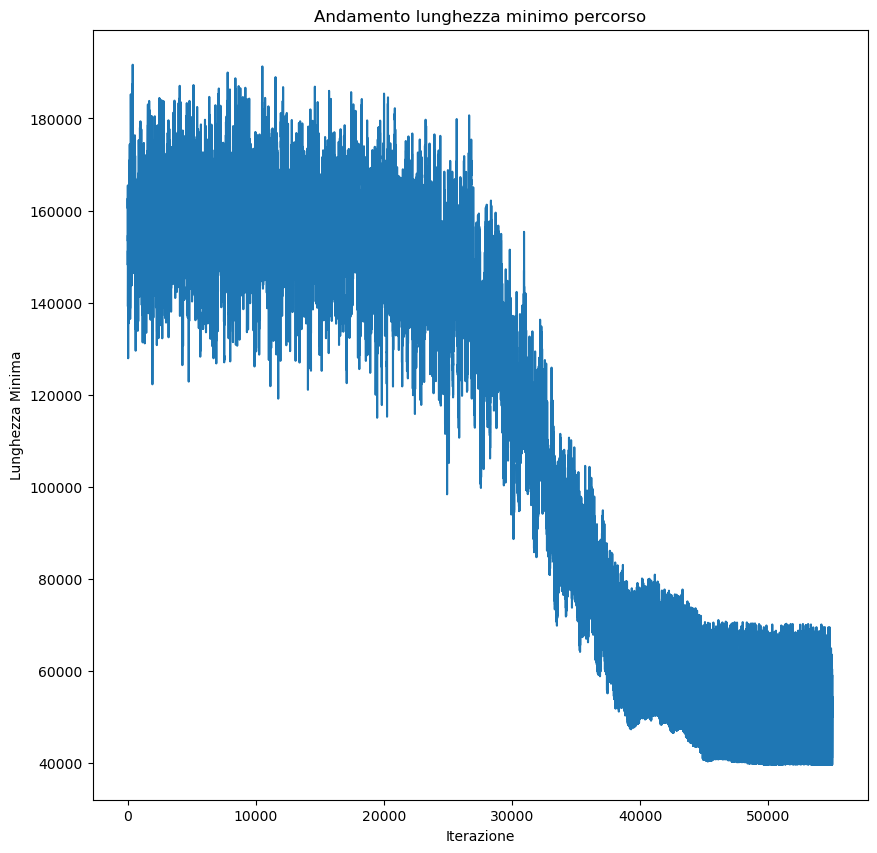

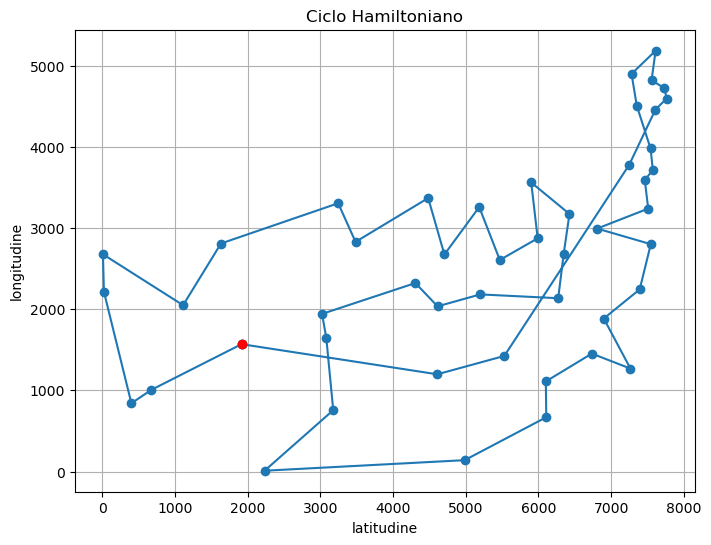

In [20]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(len(path_lengths_list)), path_lengths_list)
plt.xlabel('Iterazione')
plt.ylabel('Lunghezza Minima')
plt.title('Andamento lunghezza minimo percorso')
plt.show()

plot_tsp(cities, best_order)